# **Reto 2 - EchoNet Dynamic**
---
**Equipo Blue Leg**

Diego Sú Gómez - A01620476

Vanessa Méndez Palacios - A01639925

Estefanía Pérez Yeo - A01639270

Francisco Javier Sanchez Panduro - A01639832

Isai Ambrocio -  A01625101

## **Importación de librerías**
---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import display
import cv2
from google.colab.patches import cv2_imshow
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate,concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras import backend as K
import matplotlib.patches as patches
from scipy.spatial import ConvexHull
from skimage import measure, draw, filters
from skimage.metrics import structural_similarity as ssim
from skimage.morphology import binary_dilation, binary_erosion, disk
from scipy.ndimage import gaussian_filter
from skimage.draw import polygon

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Carga de archivos .csv con información sobre los videos**
---
El conjunto de datos con el que se va a trabajar en este proyecto es el EchoNet-Dynamic, el cual contiene 10,030 videos de ecocardiogramas de corazones etiquetados. Cada video cuenta con dos frames seleccionados específicamente para entrenamiento de redes neuronales. Un frame es cuando el corazón se encuentra en su tamaño más grande, mientras que otro es cuando el corazón se encuentra en su punto más pequeño. La idea de este dataset es aislar el ventrículo izquierdo de cada uno de los frames, y los archivos contienen coordenadas de dicha máscara.

Adicional a estos videos, el dataset contiene dos archivos .csv, el primero el cual contiene la información de las máscaras para cada uno de los frames, mientras que el segundo contiene el nombre del archivo y el split al que pertenece ese video (Train, Test, Validation).

En este bloque de código se van a cargar ambos archivos .csv para poder estudiarse a fondo y comenzar a comprender el funcionamiento del dataset.

In [ ]:
#Cargar el dataframe
df = pd.read_csv("/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/VolumeTracings.csv")
df.head()

,FileName,X1,Y1,X2,Y2,Frame
0,0X100009310A3BD7FC.avi,51.260417,15.348958,64.932292,69.125000,46
1,0X100009310A3BD7FC.avi,50.037611,17.167841,53.367222,16.321330,46
2,0X100009310A3BD7FC.avi,49.157378,20.407629,57.090549,18.390722,46
3,0X100009310A3BD7FC.avi,48.538173,23.581055,59.997339,20.667707,46
4,0X100009310A3BD7FC.avi,47.918968,26.754480,62.904129,22.944693,46


In [ ]:
df.shape

(425010, 6)

In [ ]:
#Carga de archivo de los videos de entrenamiento y validación
df2 = pd.read_csv('/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/FileList.csv')
df2.head()

,FileName,EF,ESV,EDV,FrameHeight,FrameWidth,FPS,NumberOfFrames,Split
0,0X100009310A3BD7FC,78.498406,14.881368,69.210534,112,112,50,174,VAL
1,0X1002E8FBACD08477,59.101988,40.383876,98.742884,112,112,50,215,TRAIN
2,0X1005D03EED19C65B,62.363798,14.267784,37.909734,112,112,50,104,TRAIN
3,0X10075961BC11C88E,54.545097,33.143084,72.914210,112,112,55,122,TRAIN
4,0X10094BA0A028EAC3,24.887742,127.581945,169.855024,112,112,52,207,VAL


In [ ]:
df2.shape

(10030, 9)

## **Generación de máscara con un archivo**
----
Tras haber cargado los archivos .csv, lo primero que se realizó fue cargar un archivo de video para analizar los frames del mismo, y comenzar a formar las máscaras con los puntos que se encuentran en el DataFrame. A continuación se muestra un ejemplo de la generación de la máscara en base a los puntos obtenidos en el archivo .csv

In [ ]:
#Extraer los frames de la máscara de un archivo
df_archivo = df[df["FileName"]=="0X1A0A263B22CCD966.avi"]
df_archivo.head()

,FileName,X1,Y1,X2,Y2,Frame
34179,0X1A0A263B22CCD966.avi,46.520833,21.729167,63.656250,65.479167,72
34180,0X1A0A263B22CCD966.avi,46.225063,23.232668,47.790771,22.619432,72
34181,0X1A0A263B22CCD966.avi,45.633521,26.239669,50.330645,24.399962,72
34182,0X1A0A263B22CCD966.avi,45.041980,29.246671,52.870519,26.180493,72
34183,0X1A0A263B22CCD966.avi,44.450439,32.253673,55.410394,27.961023,72


In [ ]:
#Extraer los frames específicos para ese archivo
frames = df_archivo["Frame"].unique()
frames

array([72, 83])

In [ ]:
df_archivo["Frame"].value_counts()

72    21
83    21
Name: Frame, dtype: int64

Frame 72:


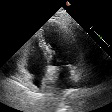

Frame 83:


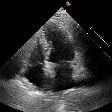

In [ ]:
#Extraer los frames del archivo
cap = cv2.VideoCapture('/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Videos incompletos/0X1A0A263B22CCD966.avi')
frames_imgs = []

# Revisar si está abierto el video
if not cap.isOpened():
    print("Error: No se pudo abrir el archivo.")
else:
    # Encontrar los frames donde están las máscaras
    for frame_number in frames:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number-1)
        ret, frame = cap.read()

        if ret:
            print(f"Frame {frame_number}:")
            frames_imgs.append(frame)
            cv2_imshow(frame)
        else:
            print(f"Error: No se pudo encontrar el frame #{frame_number}.")

    # Mostrar el frame
    cap.release()

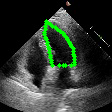

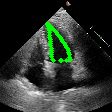

In [ ]:
# Cargar el video específico
video_folder = '/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Videos incompletos'
video_filename = '0X1A0A263B22CCD966.avi'

# Obtener los frames que cuentan con las máscaras
frame_72_dataset = df[(df['FileName'] == video_filename) & (df['Frame'] == 72)]
frame_83_dataset = df[(df['FileName'] == video_filename) & (df['Frame'] == 83)]

# Conseguir el video
video_path = os.path.join(video_folder, video_filename)
if not os.path.exists(video_path):
    print(f"Error: Video {video_path} no encontrado.")
else:
    # Abrir el video
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: No se pudo abrir el archivo: {video_path}")
    else:
        cap.set(cv2.CAP_PROP_POS_FRAMES, 71)
        ret, frame_72 = cap.read()

        if not ret:
            print(f"Error: No se pudo extraer el frame 72 de {video_path}")
        else:
            for index, row in frame_72_dataset.iterrows(): #Marcar los puntos
                x, y = int(row['X1']), int(row['Y1'])
                cv2.circle(frame_72, (x, y), 2, (0, 255, 0), -1)
                x2, y2 = int(row['X2']), int(row['Y2'])
                cv2.circle(frame_72, (x2, y2), 2, (0, 255, 0), -1)

        cap.set(cv2.CAP_PROP_POS_FRAMES, 82)
        ret, frame_83 = cap.read()

        if not ret:
            print(f"Error: No se pudo extraer el frame 83 de  {video_path}")
        else:
            for index, row in frame_83_dataset.iterrows():
                x, y = int(row['X1']), int(row['Y1'])
                cv2.circle(frame_83, (x, y), 2, (0, 255, 0), -1)
                x2, y2 = int(row['X2']), int(row['Y2'])
                cv2.circle(frame_83, (x2, y2), 2, (0, 255, 0), -1)

            # Mostrar los frames
            cv2_imshow(frame_72)
            cv2_imshow(frame_83)

        cap.release()

## **Generación de máscaras y frames**
---
Tras haber visto como funcionan las coordenadas en relación a los frames obtenidos, se generó una función para poder crear las máscaras de cada uno de los frames por video. Se utilizó el mismo código mostrado previamente, más se añadió la función de guardar tanto el frame como la máscara generada en distintas carpetas almacenadas en Google Drive. Las carpetas fueron organizadas en base al split al que pertenece cada uno de los videos, y la distribución quedó de la siguiente manera.

* Frames Entrenamiento
* Frames Prueba
* Frames Validación
* Máscaras Entrenamiento
* Máscaras Prueba
* Máscaras Validación

Después de haber generado estos fólders, se definió una función la cual itera a través de todos los videos del dataset, obtiene los frames en base al archivo .csv, genera las máscaras en base a las coordenadas y luego guarda tanto el frame como la máscara en sus respectivas carpetas dependiendo del split al que pertenecen. Tras haber terminado con este proceso, todos los frames y las máscaras se encuentran guardados en sus respectivas carpetas y se pueden acceder fácilmente sin necesidad de generarlas de nuevo.

In [ ]:
#Obtener los splits de los videos del dataset
df2["Split"].value_counts()

TRAIN    7465
VAL      1288
TEST     1277
Name: Split, dtype: int64

In [ ]:
def mask_generation():
  videos = sorted(os.listdir("/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Videos"))
  for file in videos: #Iterar por los archivos del folder
    if file.endswith(".avi"): #Seleccionar únicamente los videos
      video_name = video_name = file[:-4] #Guardar el nombre del video
      filename = file
      frames = df[df["FileName"] == filename]
      frames = frames["Frame"].unique() #Encontrar los frames de las máscaras

      video_folder = '/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Videos' #Ruta al folder con todos los videos

      if len(frames) == 2:
        # Obtener los frames que cuentan con las máscaras
        frame_A = df[(df['FileName'] == filename) & (df['Frame'] == frames[0])]
        frame_B = df[(df['FileName'] == filename) & (df['Frame'] == frames[1])]

        #Conseguir el video
        video_path = os.path.join(video_folder, filename)
        if not os.path.exists(video_path):
            print(f"Error: Video {video_path} no encontrado.")
        else:
            # Abrir el video
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                print(f"Error: No se pudo abrir el archivo: {video_path}")
            else:
                cap.set(cv2.CAP_PROP_POS_FRAMES, frames[0])
                ret, frame_Aimg = cap.read()

                # Obtén las dimensiones del frame
                alto_frame, ancho_frame, _ = frame_Aimg.shape

                # Crea un cuadro negro del mismo tamaño que el frame
                cuadro_negroA = np.zeros((alto_frame, ancho_frame, 3), dtype=np.uint8)
                cuadro_negroA[:] = (0, 0, 0)

                if not ret:
                    print(f"Error: No se pudo extraer el frame de {video_path}")
                else:
                    for index, row in frame_A.iterrows(): #Marcar los puntos
                        x, y = int(row['X1']), int(row['Y1'])
                        x2, y2 = int(row['X2']), int(row['Y2'])
                        cv2.line(cuadro_negroA,(x,y),(x2,y2),(255,255,255),5)

                cap.set(cv2.CAP_PROP_POS_FRAMES, frames[1])
                ret, frame_Bimg = cap.read()

                # Obtén las dimensiones del frame
                alto_frame, ancho_frame, _ = frame_Bimg.shape

                # Crea un cuadro negro del mismo tamaño que el frame
                cuadro_negroB = np.zeros((alto_frame, ancho_frame, 3), dtype=np.uint8)
                cuadro_negroB[:] = (0, 0, 0)

                if not ret:
                    print(f"Error: No se pudo extraer el frame de {video_path}")
                else:
                    for index, row in frame_B.iterrows():
                        x, y = int(row['X1']), int(row['Y1'])
                        x2, y2 = int(row['X2']), int(row['Y2'])
                        cv2.line(cuadro_negroB,(x,y),(x2,y2),(255,255,255),5)

                    # Mostrar los frames
                    # print(f"Frame {frames[0]} de {video_name}:")
                    # cv2_imshow(cuadro_negroA)
                    # print(f"Frame {frames[1]} de {video_name}:")
                    # cv2_imshow(cuadro_negroB)

                    # Especifica la ruta del archivo JPG en la que deseas guardar la máscara
                    split = df2.loc[df2["FileName"] == video_name, "Split"].values[0]
                    if split == "TRAIN":
                      ruta_archivo_jpg = '/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Mascaras_Training'
                    elif split  == "TEST":
                      ruta_archivo_jpg = '/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Mascaras_Test'
                    else:
                      ruta_archivo_jpg = '/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Mascaras_Validation'

                    nombreA = video_name+ '_Frame1' + '.jpg'
                    nombreB = video_name+ '_Frame2' + '.jpg'

                    #print(nombreA,split,ruta_archivo_jpg, ruta_archivo_jpg)
                    #print(nombreB,split,ruta_archivo_jpg, ruta_archivo_jpg)

                    # Guarda la máscara como un archivo JPG
                    cv2.imwrite(os.path.join(ruta_archivo_jpg , nombreA), cuadro_negroA)
                    cv2.imwrite(os.path.join(ruta_archivo_jpg , nombreB), cuadro_negroB)

                    # Verifica si se guardó correctamente
                    if os.path.exists(ruta_archivo_jpg):
                        print(f"La máscara {nombreA} - {nombreB} se ha guardado en {ruta_archivo_jpg}")
                    else:
                        print(f"Error al guardar la máscara en {ruta_archivo_jpg}")


                    # Especifica la ruta del archivo JPG en la que deseas guardar el frame
                    if split == "TRAIN":
                      ruta_archivo_frames_jpg = '/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Frames_Training'
                    elif split  == "TEST":
                      ruta_archivo_frames_jpg = '/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Frames_Test'
                    else:
                      ruta_archivo_frames_jpg = '/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Frames_Validation'


                    nombreA = video_name+ '_Frame1' + '.jpg'
                    nombreB = video_name+ '_Frame2' + '.jpg'

                    #print(nombreA,split,ruta_archivo_frames_jpg)
                    #print(nombreB,split,ruta_archivo_frames_jpg)

                    # Guarda el archivo como un archivo JPG
                    cv2.imwrite(os.path.join(ruta_archivo_frames_jpg , nombreA), frame_Aimg)
                    cv2.imwrite(os.path.join(ruta_archivo_frames_jpg , nombreB), frame_Bimg)

                    # Verifica si se guardó correctamente
                    if os.path.exists(ruta_archivo_jpg):
                        print(f"El frame {nombreA} - {nombreB} se ha guardado en {ruta_archivo_frames_jpg}")
                    else:
                        print(f"Error al guardar el frame en {ruta_archivo_frames_jpg}")

                cap.release()

In [ ]:
#Generar las máscaras y almacenarlas en su respectivo folder
#mask_generation()

## **Descarga de las máscaras y frames**
---
Tras haber generado todas las máscaras y haber guardado los frames, se generó una función con el objetivo de seleccionar un directorio y un número específico de frames/máscaras, para poder entrenar un modelo posteriormente. Con esta función generada es muy simple el poder obtener una cantidad específica de frames y máscaras para poder usarlas en el entrenamiento de una red neuronal.

Esta función opera mediante el directorio especificado, se seleccionan los archivos del mismo, y luego se seleccionan únicamente los primeros **N** archivos de la carpeta. Después de haber realizado eso, se normalizan cada una de las imágenes y se guardan en un arreglo para su fácil acceso y manipulación.

In [ ]:
#Función para obtener las imágenes de las máscaras/frames dependiendo de un folder
def get_images(route, number=0):
  list_imgs = []
  names_files = []
  files = sorted(os.listdir(route))
  if number != 0:
    files_number = files[:number]

  #Guardar cada mascara en la lista
  for archivo in files_number:
    #print(archivo)
    if archivo.endswith(".jpg"):
      archivo_mascara = os.path.join(route,archivo)
      mask = cv2.imread(archivo_mascara,cv2.IMREAD_GRAYSCALE)
      mask = mask/255.0
      list_imgs.append(mask)
      names_files.append(archivo)

  list_imgs = np.array(list_imgs)
  return list_imgs, names_files

In [ ]:
#Obtener las máscaras de entrenamiento
lista_mascaras, nombres_mascaras = get_images('/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Mascaras_Training',2000)

In [ ]:
lista_mascaras.shape

(2000, 112, 112)

In [ ]:
lista_mascaras.dtype

dtype('float64')

In [ ]:
#Normalizar las máscaras para que queden valores binarios (0,1)
lista_mascaras[lista_mascaras < 0.5] = 0.0
lista_mascaras[lista_mascaras >= 0.5] = 1.0

In [ ]:
np.unique(lista_mascaras[0])

array([0., 1.])

In [ ]:
#Obtener los frames de entrenamiento
lista_frames, _ = get_images('/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Frames_Training', 2000)

In [ ]:
lista_frames.shape

(2000, 112, 112)

In [ ]:
lista_frames.dtype

dtype('float64')

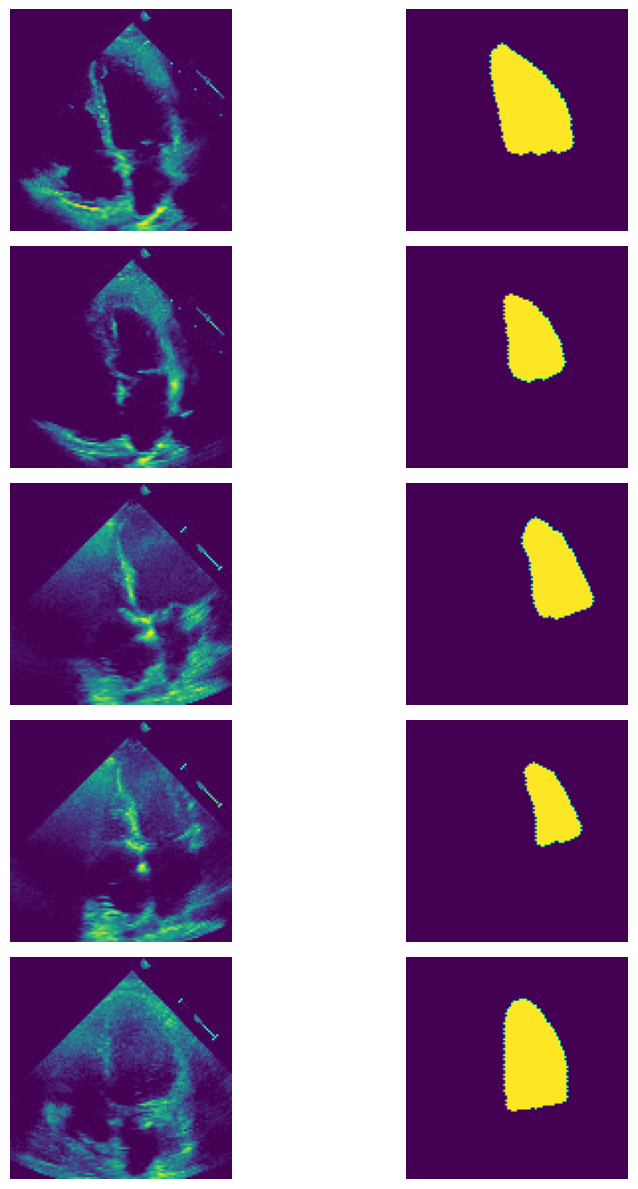

In [ ]:
figure, axis = plt.subplots(5,2,figsize=(10,12))
axis = axis.flatten()
img = 0
for i in [0,2,4,6,8]:
  axis[i].imshow(lista_frames[img])
  axis[i].axis("off")
  axis[i+1].imshow(lista_mascaras[img])
  axis[i+1].axis("off")
  img +=1

plt.tight_layout()

In [ ]:
#Guardar las imágenes y frames para conjuntos de validación y testing
mascaras_test, nombres_test = get_images('/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Mascaras_Test',1000)
frames_test, _ = get_images('/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Frames_Test',1000)
mascaras_val, nombres_val = get_images('/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Mascaras_Validation',1000)
frames_val, _ = get_images('/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/Frames_Validation',1000)

In [ ]:
#Normalizar las máscaras de testing y de validación para que queden valores binarios
mascaras_test[mascaras_test < 0.5] = 0.0
mascaras_test[mascaras_test >= 0.5] = 1.0
mascaras_val[mascaras_val < 0.5] = 0.0
mascaras_val[mascaras_val >= 0.5] = 1.0

In [ ]:
np.unique(mascaras_test)

array([0., 1.])

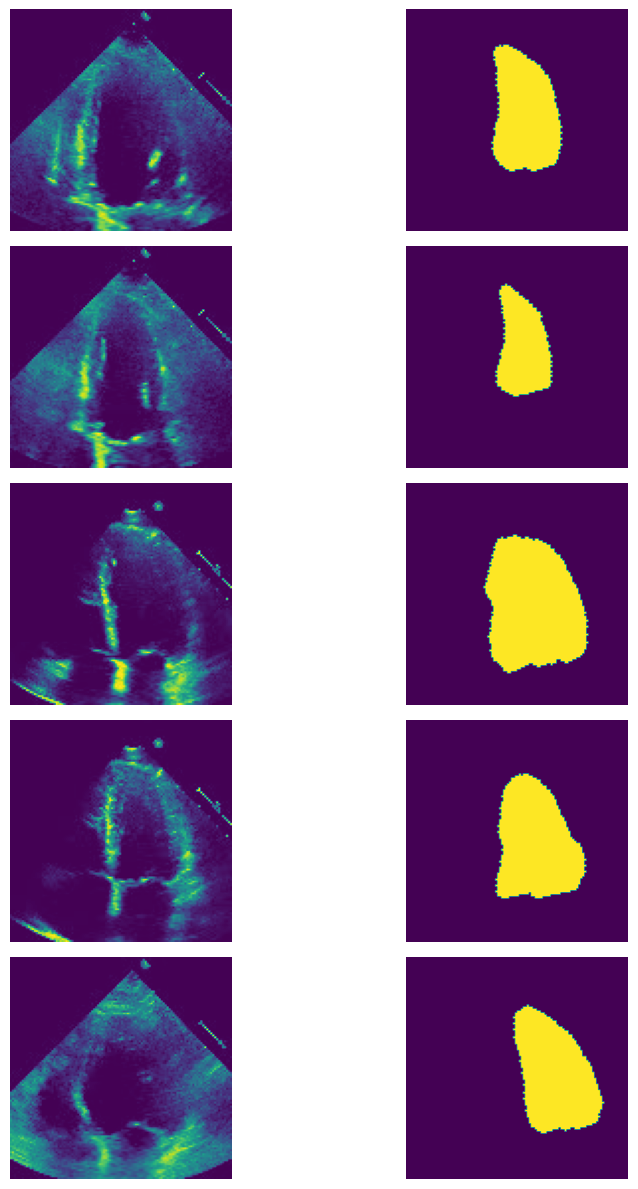

In [ ]:
figure, axis = plt.subplots(5,2,figsize=(10,12))
axis = axis.flatten()
img = 0
for i in [0,2,4,6,8]:
  axis[i].imshow(frames_test[img])
  axis[i].axis("off")
  axis[i+1].imshow(mascaras_test[img])
  axis[i+1].axis("off")
  img +=1

plt.tight_layout()

In [ ]:
np.unique(mascaras_val)

array([0., 1.])

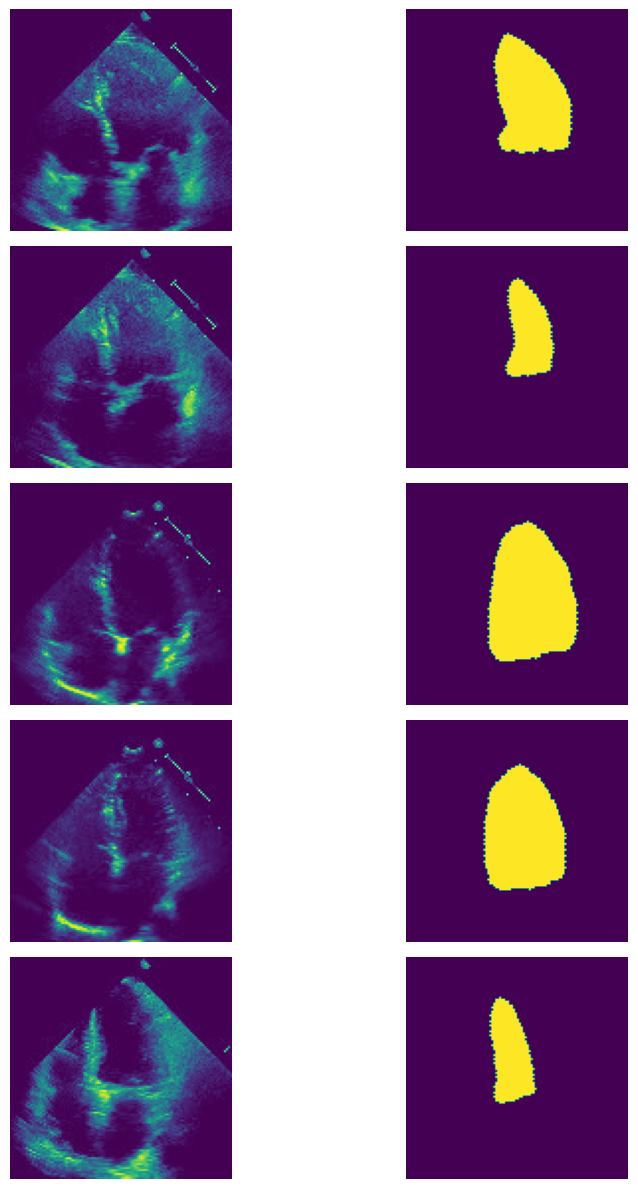

In [ ]:
figure, axis = plt.subplots(5,2,figsize=(10,12))
axis = axis.flatten()
img = 0
for i in [0,2,4,6,8]:
  axis[i].imshow(frames_val[img])
  axis[i].axis("off")
  axis[i+1].imshow(mascaras_val[img])
  axis[i+1].axis("off")
  img +=1

plt.tight_layout()

## **Entrenamiento de una red neuronal con máscaras**
---
Después de haber descargado los frames y máscaras tanto de entrenamiento como de prueba y validación, lo siguiente que se realizó fue generar la red neuronal para poder realizar predicciones. El primer método que se utilizó fue el de realizar las predicciones en base a las máscaras obtenidas, enviando como entradas los frames con sus respectivas máscaras, y buscando que la salida de la red neuronal sean máscaras similares.

La arquitectura elegida fue la U-Net. La U-Net es una arquitectura de redes neuronales utilizadas para segmentación de imágenes. Está compuesta por dos partes principales: Contracción y expansión. Es una red convolucional la cual va reduciendo la imagen mientras la estira horizontalmente y luego viceversa. Con esto se busca encontrar relaciones entre los valores de entrada y poder empezar a definir criterios para las predicciones.

Esta red fue entrenada con los frames y máscaras de entrenamiento, utilizando como optimizador el Adam, mientras que la función de pérdida fue tanto la "binary crossentropy" y el "mean squared error", estas dos métricas fueron útiles para obtener los resultados más acertados con las máscaras obtenidas. El proceso que se siguió fue el siguiente

In [ ]:
#Generar la U-Net para predecir las máscaras
def unet():
  input = Input((112,112,1))
  conv1 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(input)
  conv1 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(conv1)
  pool1 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv1)
  pool1 = BatchNormalization()(pool1)
  drop1 = Dropout(0.2)(pool1)
  conv2 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(drop1)
  conv2 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(conv2)
  pool2 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv2)
  drop2 = Dropout(0.2)(pool2)

  conv3 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(drop2)
  conv3 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(conv3)
  pool3 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv3)
  pool3 = BatchNormalization()(pool3)
  drop3 = Dropout(0.2)(pool3)

  conv4 = Conv2D(1024, (3,3), activation = 'relu', padding = 'same')(drop3)
  conv4 = Conv2D(1024, (3,3), activation = 'relu', padding = 'same')(conv4)
  pool4 = MaxPooling2D((2,2), strides = 2, padding = 'same')(conv4)
  pool4 = BatchNormalization()(pool4)
  drop4 = Dropout(0.2)(pool4)
  convm = Conv2D(2048, (3,3), activation = 'relu', padding = 'same')(drop4)
  convm = Conv2D(2048, (3,3), activation = 'relu', padding = 'same')(convm)
  tran5 = Conv2DTranspose(512, (2,2), strides = 2, padding = 'valid', activation = 'relu')(convm)
  tran5 = BatchNormalization()(tran5)
  conc5 = Concatenate()([tran5, conv4])
  conv5 = Conv2D(1024, (3,3), activation = 'relu', padding = 'same')(conc5)
  conv5 = Conv2D(1024, (3,3), activation = 'relu', padding = 'same')(conv5)
  drop5 = Dropout(0.1)(conv5)

  tran6 = Conv2DTranspose(256, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop5)
  tran6 = BatchNormalization()(tran6)
  conc6 = Concatenate()([tran6, conv3])
  conv6 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(conc6)
  conv6 = Conv2D(512, (3,3), activation = 'relu', padding = 'same')(conv6)
  conv6 = BatchNormalization()(conv6)
  drop6 = Dropout(0.1)(conv6)

  tran7 = Conv2DTranspose(128, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop6)
  conc7 = Concatenate()([tran7, conv2])
  conv7 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(conc7)
  conv7 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(conv7)
  conv7 = BatchNormalization()(conv7)
  drop7 = Dropout(0.1)(conv7)

  tran8 = Conv2DTranspose(64, (2,2), strides = 2, padding = 'valid', activation = 'relu')(drop7)
  conc8 = Concatenate()([tran8, conv1])
  conv8 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(conc8)
  conv8 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(conv8)
  conv8 = BatchNormalization()(conv8)
  drop8 = Dropout(0.1)(conv8)
  output = Conv2D(1, (1,1), activation = 'relu', padding = 'same')(drop8)
  model = Model(inputs = input, outputs = output)

  return model

In [ ]:
# Define una función para calcular el coeficiente de Dice
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)

    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

#Definir la función de pérdida del Dice Coefficient
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

#Calcular la pérdida en base al Dice Coefficient
def combined_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    dice = dice_loss(y_true, y_pred)
    bce = binary_crossentropy(y_true, y_pred)
    return alpha * bce+beta*dice

In [ ]:
#Inicializar la red neuronal
model = unet()

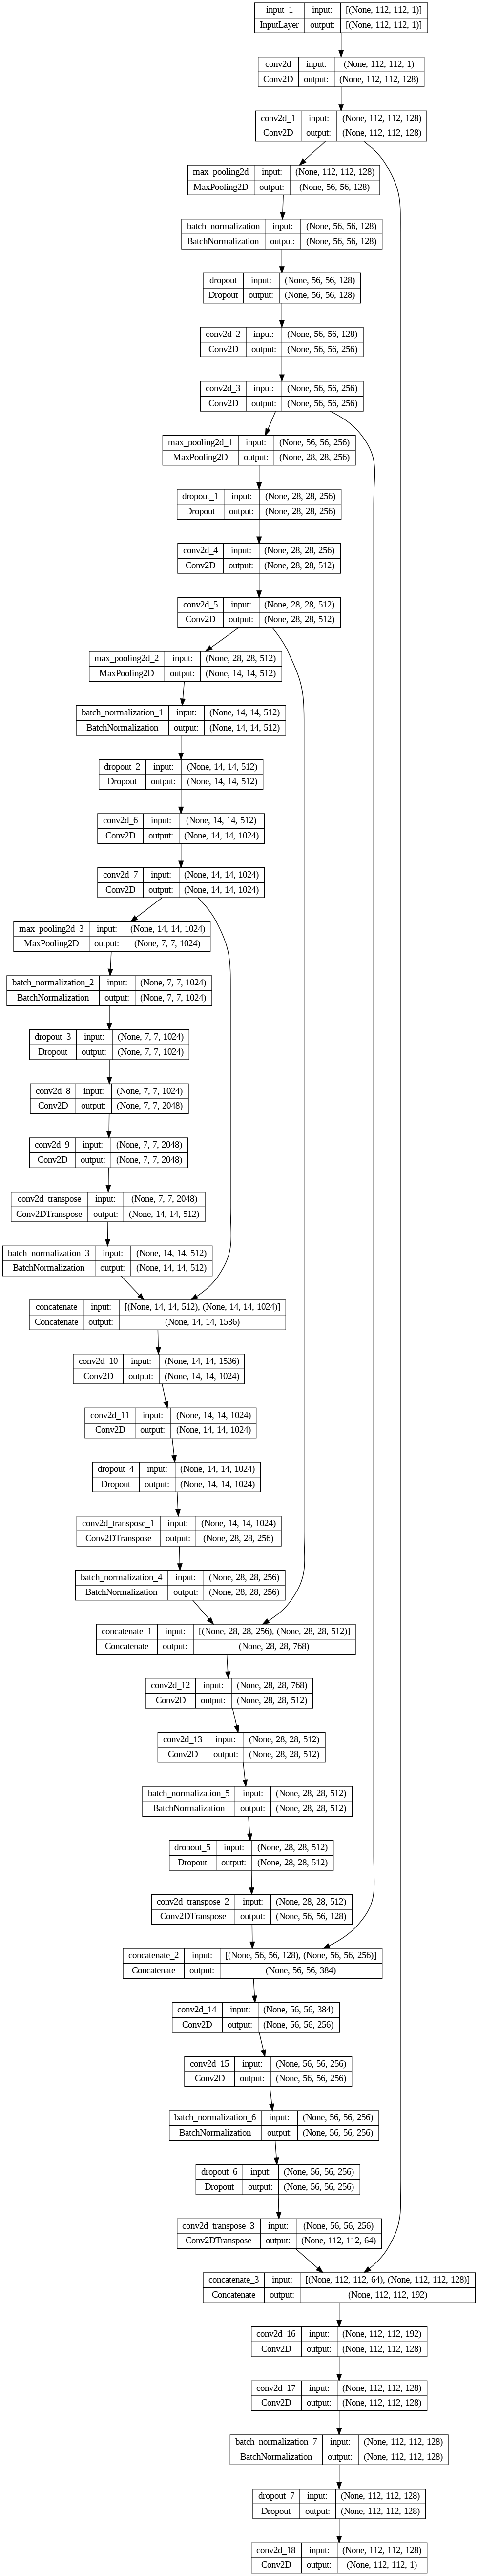

In [ ]:
keras.utils.plot_model(model, to_file="unet-mascaras.png", show_shapes=True, show_layer_names=True)

In [ ]:
#Compilar la red neuronal con función de pérdida, optimizador, métricas y épocas
model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), metrics=["accuracy", dice_coefficient])

In [ ]:
#Guardar el modelo
model.save("model.h5")

  saving_api.save_model(



In [ ]:
#Definir un checkpoint para guardar el modelo con la menor pérdida en la validación
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="model.h5",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    verbose=1)

In [ ]:
#Entrenar el modelo
history = model.fit(lista_frames, lista_mascaras, epochs=100, validation_data=(frames_val, mascaras_val), callbacks=[checkpoint])

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.1979 - accuracy: 0.8453 - dice_coefficient: 0.1339
Epoch 1: val_loss improved from inf to 0.12857, saving model to model.h5
63/63 [==============================] - 125s 1s/step - loss: 0.1979 - accuracy: 0.8453 - dice_coefficient: 0.1339 - val_loss: 0.1286 - val_accuracy: 0.8714 - val_dice_coefficient: 2.1925e-05
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 0.0969 - accuracy: 0.8742 - dice_coefficient: 0.2790
Epoch 2: val_loss improved from 0.12857 to 0.12696, saving model to model.h5
63/63 [==============================] - 70s 1s/step - loss: 0.0969 - accuracy: 0.8742 - dice_coefficient: 0.2790 - val_loss: 0.1270 - val_accuracy: 0.8714 - val_dice_coefficient: 0.0189
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 0.0844 - accuracy: 0.8855 - dice_coefficient: 0.3694
Epoch 3: val_loss did not improve from 0.12696
63/63 [==============================] - 70s 1s/step - los

(0.5, 1.0)

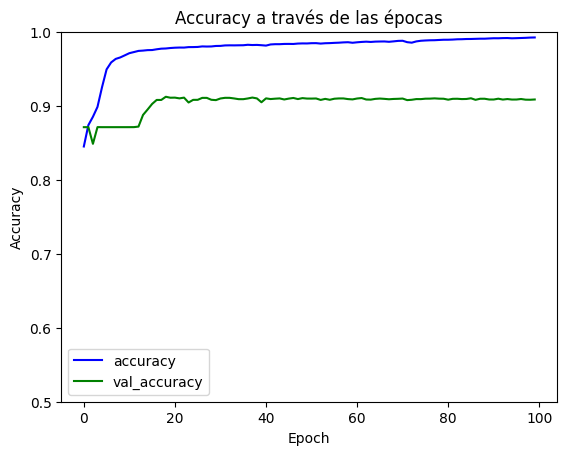

In [ ]:
#Graficar la precisión obtenida con el entrenamiento vs la precisión durante la validación
plt.plot(history.history["accuracy"], label="accuracy", color="blue")
plt.plot(history.history["val_accuracy"], label="val_accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy a través de las épocas")
plt.legend()
plt.ylim([0.5,1])

In [ ]:
#Guardar el modelo óptimo ya entrenado
model.save("model.h5")

Tras haber entrenado el modelo con las máscaras, se descargó para evitar el re-entrenamiento y poder realizar las predicciones sin necesidad de entrenar el modelo de nuevo. El modelo ya entrenado se guardó en el mismo Google Drive y se puede acceder de forma fácil.

In [ ]:
#Guardar el Dice coefficient para el modelo descargado
custom_objects = {'dice_coefficient': dice_coefficient}

In [ ]:
#Cargar el modelo ya entrenado
modelo1 = load_model("/content/drive/Shareddrives/TC2007B Team 2 Bravo/Blue Leg/ModelMasks.h5", custom_objects=custom_objects)

In [ ]:
#Realizar las predicciones
predicciones_masks = modelo1.predict(frames_test[:500])

16/16 [==============================] - 11s 410ms/step


In [ ]:
#predicciones_b = np.where(predicciones > 0.5, 1, 0)

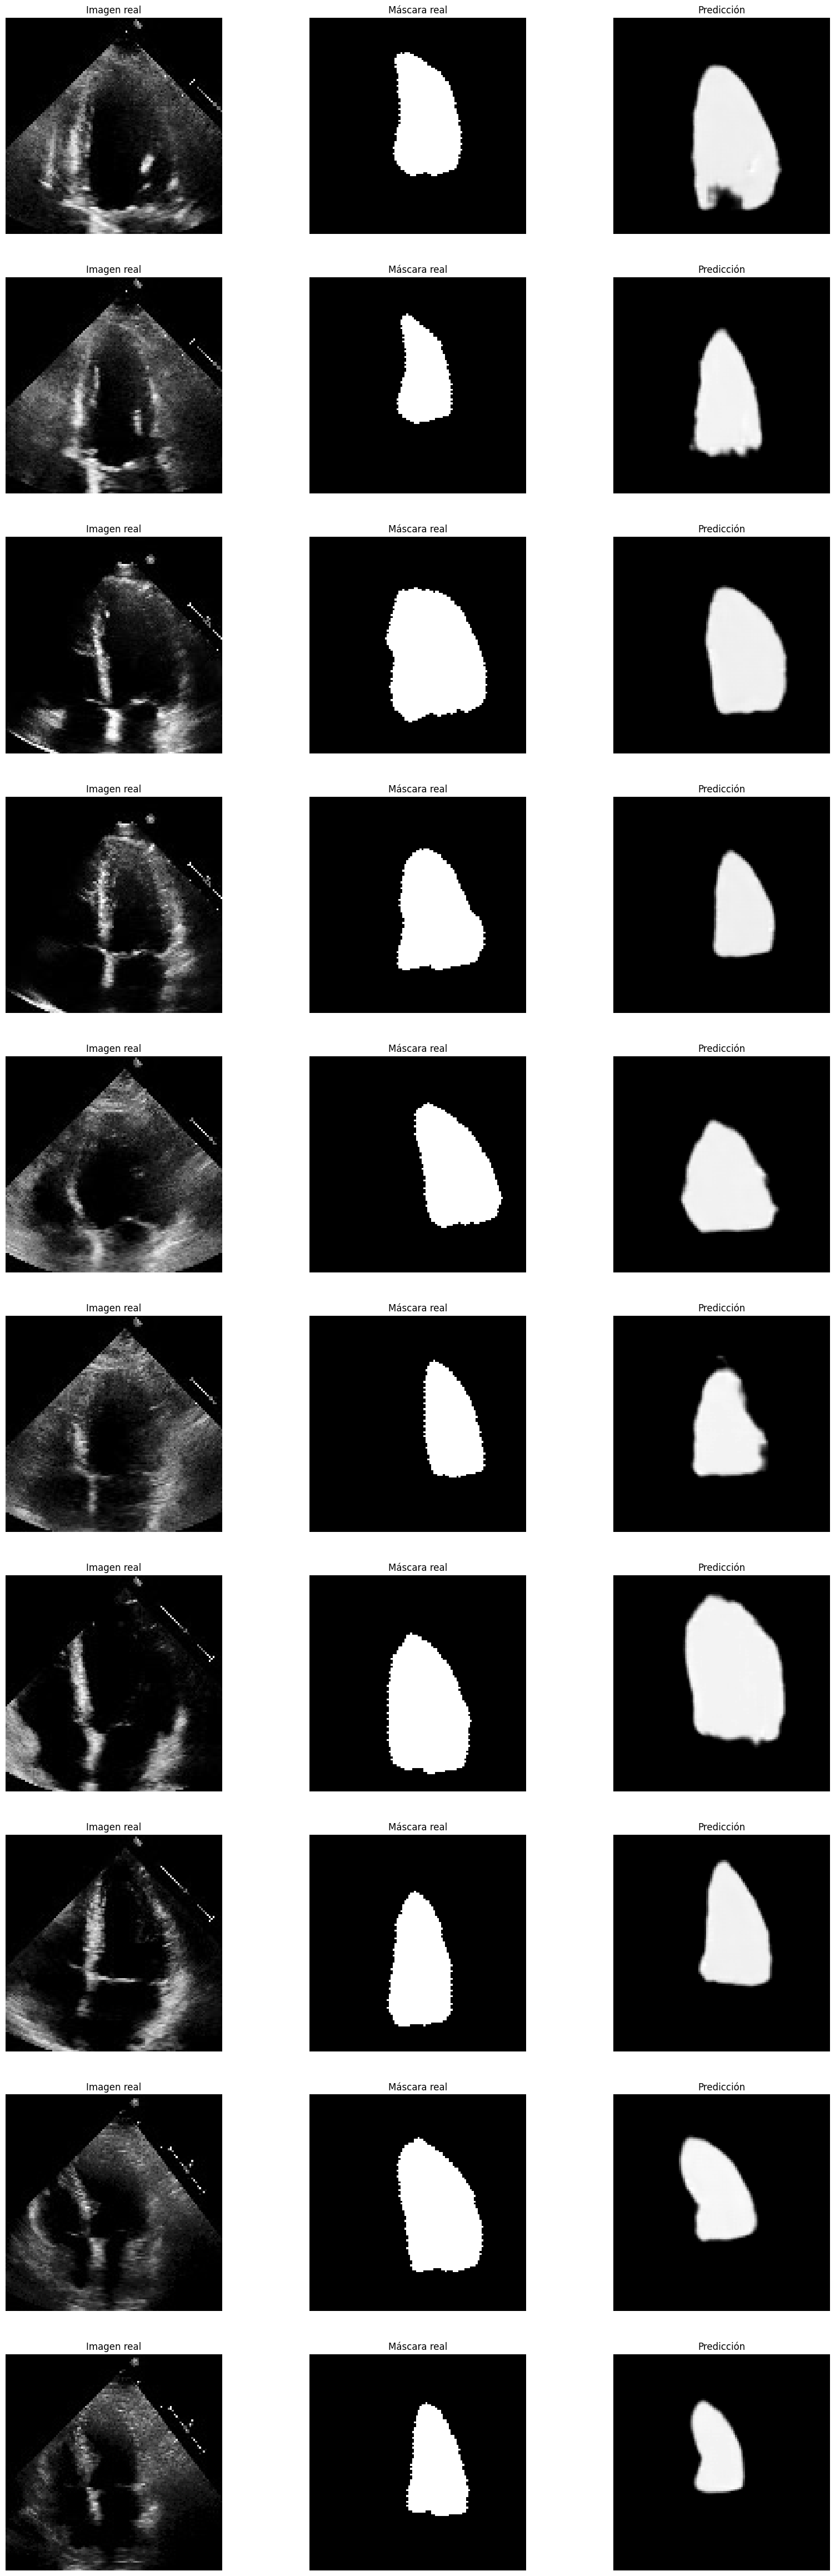

In [ ]:
#Mostrar los resultados de la red neuronal comparándolos con la máscara y el frame original
plt.figure(figsize=(20,90))
i = 0
x = 0
while i < 30:
  plt.subplot(15,3,i+1)
  plt.imshow(frames_test[x], cmap="gray")
  plt.title("Imagen real")
  plt.axis("off")

  plt.subplot(15,3,i+2)
  plt.imshow(mascaras_test[x], cmap="gray")
  plt.title("Máscara real")
  plt.axis("off")

  plt.subplot(15,3,i+3)
  plt.imshow(predicciones[x], cmap="gray")
  plt.title("Predicción")
  plt.axis("off")

  i+=3
  x+=1

## **Entrenamiento de una red neuronal utilizando landmarks**
---
Después de haber entrenado la U-Net en base a las máscaras obtenidas, se decidió también tomar otro approach distinto. Además de haber formado las máscaras, lo siguiente que se hizo fue usar las máscaras para generar landmarks, que constan de puntos clave alrededor de cada una de las máscaras, para generar 8 landmarks alrededor de la silueta de cada máscara. Con estos landmarks definidos, se generaron imágenes de 8 canales, en donde cada canal consta de un punto específico, y se entrenará la misma arquitectura con la intención de que al entrenar se genere cada landmark en cada uno de los canales, para después formar la máscara resultante.

In [ ]:
#Generar los landmarks de cada una de las máscaras y guardarlas en imágenes (112,112,8)
def generate_landmarks(masks):
  landmarks = []

  for mask in masks:
    contours = measure.find_contours(mask, 0.5)
    idx = np.linspace(0, len(contours[0])-1, 18, dtype=int)
    points = contours[0][idx]
    image = np.zeros((112,112,8))
    for i in range(8):
      si = i * 2 % 18
      ei = (i * 2 + 1) % 18
      x, y = draw.line(int(points[si][0]), int(points[si][1]), int(points[ei][0]), int(points[ei][1]))
      image[x,y,i] = 1.0
      image[:,:,i] = binary_dilation(image[:,:,i], disk(1))
      image[:,:,i] = filters.gaussian(image[:,:,i], sigma=1)

    maxv = np.max(image, axis=(0,1))
    image = image / maxv[np.newaxis, np.newaxis, :]
    #image = np.sum(image, axis=2)
    landmarks.append(image)

  landmarks = np.array(landmarks)
  return landmarks

In [ ]:
#Definir los landmarks de entrenamiento
landmarks_train = generate_landmarks(lista_mascaras)

In [ ]:
landmarks_train.shape

(2000, 112, 112, 8)

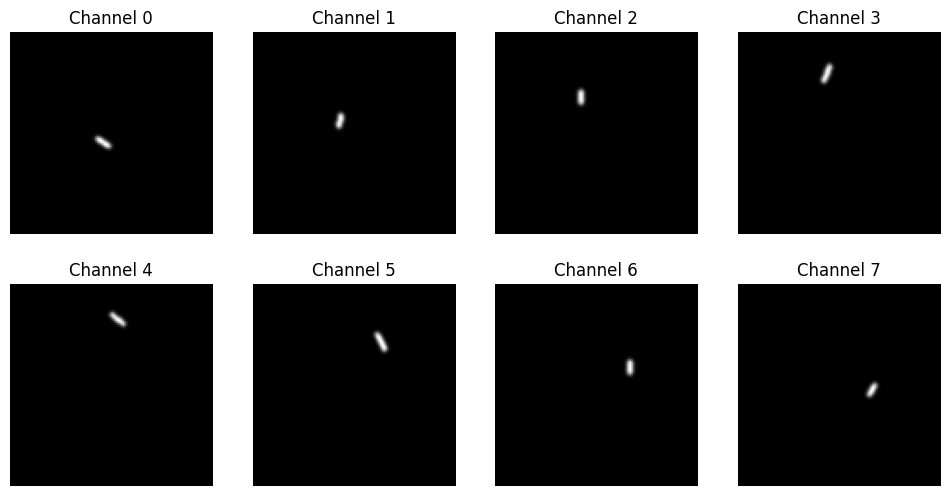

In [ ]:
#Mostrar cada landmark en cada uno de los canales de la imagen
img = landmarks_train[15]
num_channels = img.shape[2]

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i in range(num_channels):
    row = i // 4
    col = i % 4
    channel_image = img[:, :, i]
    axes[row, col].imshow(channel_image, cmap='gray')
    axes[row, col].set_title(f'Channel {i}')
    axes[row, col].axis('off')

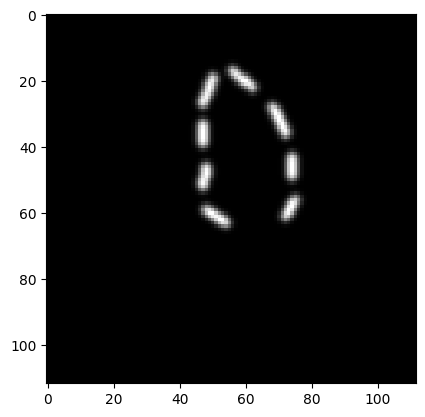

In [ ]:
img = np.sum(img, axis = 2)
plt.imshow(img, cmap="gray")

In [ ]:
#Generar los landmarks de validación
landmarks_val = generate_landmarks(mascaras_val)

In [ ]:
landmarks_val.shape

(1000, 112, 112, 8)

In [ ]:
#Generar los landmarks de prueba
landmarks_test = generate_landmarks(mascaras_test)

In [ ]:
landmarks_test.shape

(1000, 112, 112, 8)

In [ ]:
#Generar la U-Net para predecir los landmarks
def unet_landmarks():
    inputs = Input(shape=(112,112,1))

    conv1 = Conv2D(128, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(128, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = BatchNormalization()(pool1)
    drop1 = Dropout(0.2)(pool1)
    conv2 = Conv2D(256, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(256, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.2)(pool2)

    conv3 = Conv2D(512, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(512, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = BatchNormalization()(pool3)
    drop3 = Dropout(0.2)(pool3)

    conv4 = Conv2D(1024, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(1024, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.2)(conv4)
    up5 = UpSampling2D(size=(2, 2))(conv4)
    concat5 = Concatenate()([conv3, up5])
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(concat5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    drop5 = Dropout(0.1)(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    concat6 = Concatenate()([conv2, up6])
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(concat6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    drop6 = Dropout(0.1)(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    concat7 = Concatenate()([conv1, up7])
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(concat7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    drop7 = Dropout(0.1)(conv7)

    output = Conv2D(8, 1, activation='sigmoid', padding='same')(conv7)
    model = Model(inputs=inputs, outputs=output)

    return model

In [ ]:
#Cargar la red neuronal
model2 = unet_landmarks()

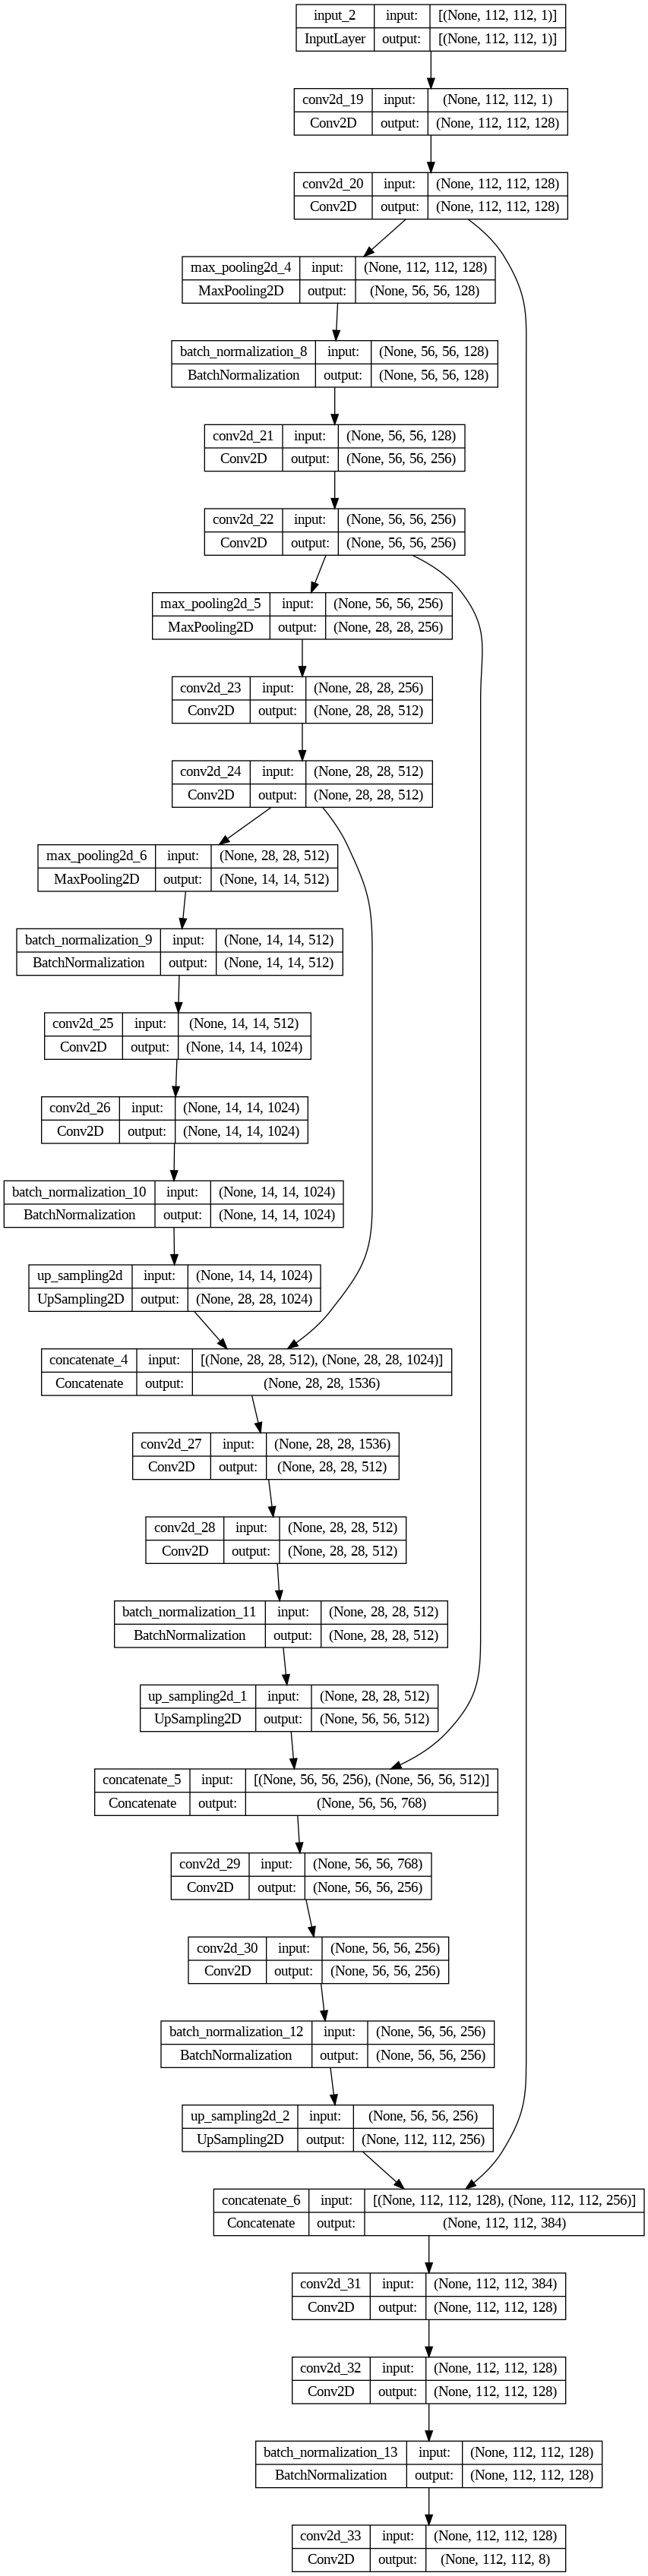

In [ ]:
keras.utils.plot_model(model2, to_file="unet-landmarks.png", show_shapes=True, show_layer_names=True)

In [ ]:
#Guardar el modelo para descargarlo
model2.save("model_landmarks.h5")

  saving_api.save_model(



In [ ]:
#Entrenar el modelo
model2.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
#Definir un checkpoint para guardar el modelo con mejores resultados
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="model_landmarks.h5",
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_weights_only=True,
    verbose=1)

In [ ]:
history2 = model2.fit(lista_frames, landmarks_train, epochs=100, validation_data=(frames_val, landmarks_val), callbacks=[checkpoint])

Epoch 1/100
63/63 [==============================] - ETA: 0s - loss: 0.1308
Epoch 1: val_loss improved from inf to 0.77254, saving model to model_landmarks.h5
63/63 [==============================] - 110s 1s/step - loss: 0.1308 - val_loss: 0.7725
Epoch 2/100
63/63 [==============================] - ETA: 0s - loss: 0.0406
Epoch 2: val_loss improved from 0.77254 to 0.75050, saving model to model_landmarks.h5
63/63 [==============================] - 58s 917ms/step - loss: 0.0406 - val_loss: 0.7505
Epoch 3/100
63/63 [==============================] - ETA: 0s - loss: 0.0185
Epoch 3: val_loss improved from 0.75050 to 0.00183, saving model to model_landmarks.h5
63/63 [==============================] - 56s 898ms/step - loss: 0.0185 - val_loss: 0.0018
Epoch 4/100
63/63 [==============================] - ETA: 0s - loss: 0.0085
Epoch 4: val_loss did not improve from 0.00183
63/63 [==============================] - 56s 887ms/step - loss: 0.0085 - val_loss: 0.0018
Epoch 5/100
63/63 [===============

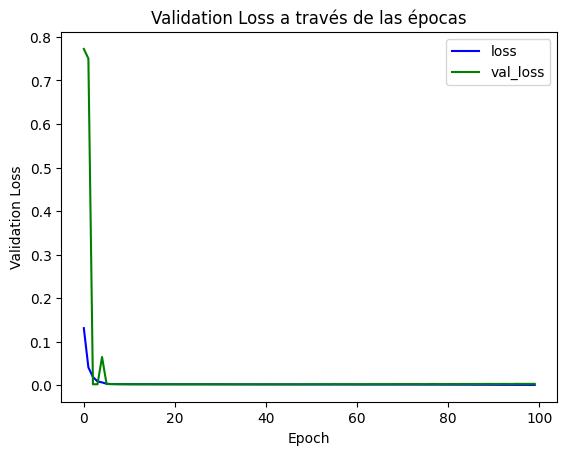

In [ ]:
1#Graficar la pérdida obtenida con el entrenamiento vs la pérdida durante la validación
plt.plot(history2.history["loss"], label="loss", color="blue")
plt.plot(history2.history["val_loss"], label="val_loss", color="green")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss a través de las épocas")
plt.legend()

In [ ]:
#Generar las predicciones
predicciones = model2.predict(frames_test[:500])

16/16 [==============================] - 3s 221ms/step


In [ ]:
predicciones.shape

(500, 112, 112, 8)

In [ ]:
#Definir una función para formar la máscara en base a los landmarks
def process_landmarks(landmarks):
  masks = []

  for i in range(len(landmarks)):
    image = landmarks[i]
    mask = np.zeros_like(image)
    #Encontrar el valor más grande en cada uno de los canales y guardarlo en la imagen nueva
    for ch in range(8):
      idx = np.unravel_index(np.argmax(image[:,:,ch]), image[:,:,ch].shape)
      mask[idx[0], idx[1], ch] = 255.0

    #Juntar todos los canales en uno solo
    mask = np.sum(mask, axis=2)
    points = np.argwhere(mask == 255.0)
    hull = ConvexHull(points) #Formar la máscara
    mask = np.zeros_like(mask, dtype=np.uint8)
    cv2.polylines(mask, [hull.points[hull.vertices].astype(int)], isClosed=True, color=255, thickness=1)
    cv2.fillPoly(mask, [hull.points[hull.vertices].astype(int)], color=255)
    mask = np.rot90(mask, k=-1) #Postprocesamiento de la máscara formada
    mask = np.fliplr(mask)
    masks.append(mask)

  return masks

In [ ]:
predicciones = process_landmarks(predicciones)

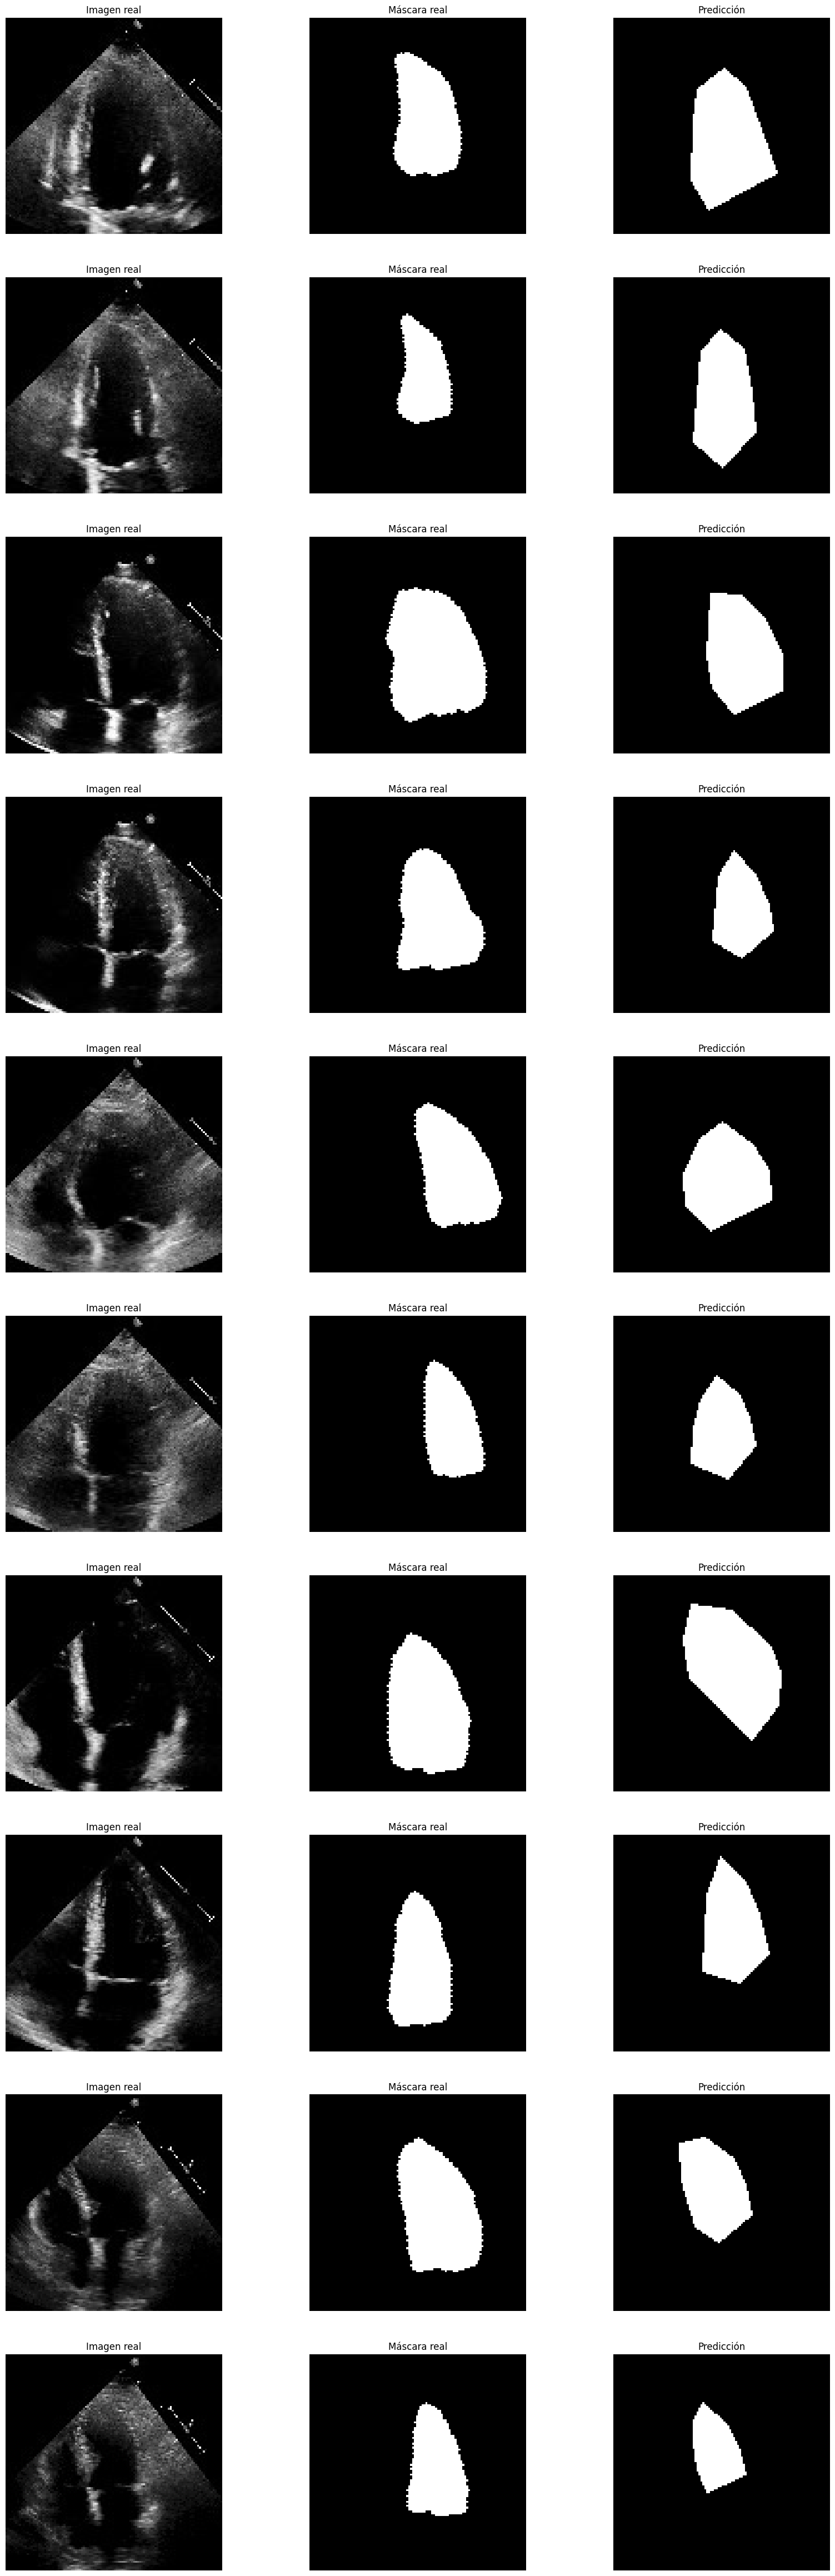

In [ ]:
plt.figure(figsize=(20,90))
i = 0
x = 0
while i < 30:
  plt.subplot(15,3,i+1)
  plt.imshow(frames_test[x], cmap="gray")
  plt.title("Imagen real")
  plt.axis("off")

  plt.subplot(15,3,i+2)
  plt.imshow(mascaras_test[x], cmap="gray")
  plt.title("Máscara real")
  plt.axis("off")

  plt.subplot(15,3,i+3)
  plt.imshow(predicciones[x], cmap="gray")
  plt.title("Predicción")
  plt.axis("off")

  i+=3
  x+=1

## **Comparación de los resultados obtenidos**
---
Para comparar los resultados obtenidos, y su respectiva precisión en comparación con los resultados reales, se utilizará el índice de similaridad estructural, el cual compara las formas dentro de las imágenes para encontrar un coeficiente de similaridad, el cual se encuentra entre 0 y 1. Este índice permite indicar qué tan similares son las máscaras predichas por el modelo en comparación con el resultado original y dar una idea de qué modelo es más adecuado para este escenario.

In [ ]:
#Definir una función para comparar las máscaras generadas con las originales
def compare(masks, predictions):
  ssims = []

  for i in range(len(masks)):
    idx = ssim(masks[i], predictions[i])
    ssims.append(idx)

  return ssims

In [ ]:
values_landmarks = compare(mascaras_test[:500].astype(np.uint8), predicciones)

In [ ]:
predicciones_masks = [img.reshape((112,112)) for img in predicciones_masks]

In [ ]:
values_masks = compare(mascaras_test[:500].astype(np.uint8), predicciones_masks)

  return func(*args, **kwargs)



Text(0.5, 1.0, 'Índice de similaridad estructural por predicción (Máscaras)')

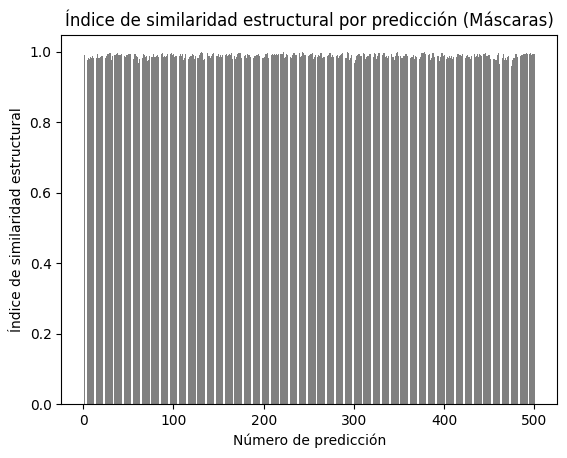

In [ ]:
#Graficar el SSI dependiendo del número de la predicciones
x = range(1,len(values_masks)+1)
plt.bar(x,values_masks, color="gray")
plt.xlabel("Número de predicción")
plt.ylabel("Índice de similaridad estructural")
plt.title("Índice de similaridad estructural por predicción (Máscaras)")

Text(0.5, 1.0, 'Histograma del SSI (Máscaras)')

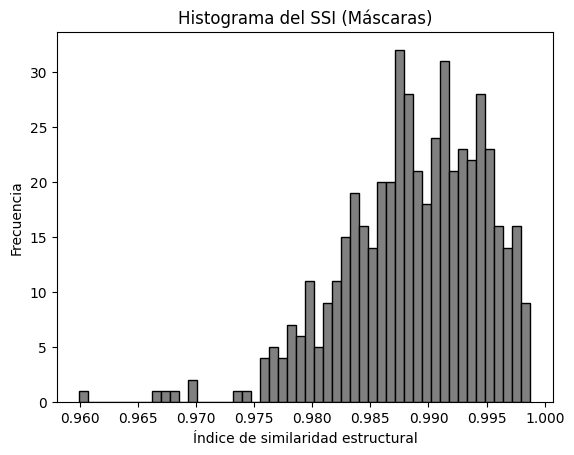

In [ ]:
plt.hist(values_masks, bins=50, color="gray", edgecolor="black")
plt.xlabel("Índice de similaridad estructural")
plt.ylabel("Frecuencia")
plt.title("Histograma del SSI (Máscaras)")

Text(0.5, 1.0, 'Índice de similaridad estructural por predicción (Landmarks)')

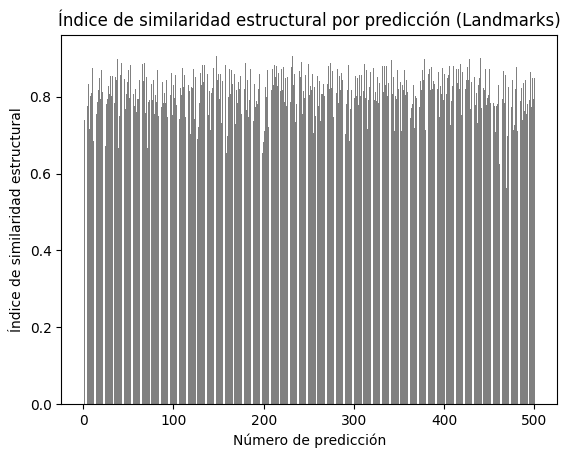

In [ ]:
#Graficar el SSI dependiendo del número de la predicciones
x = range(1,len(values_landmarks)+1)
plt.bar(x,values_landmarks, color="gray")
plt.xlabel("Número de predicción")
plt.ylabel("Índice de similaridad estructural")
plt.title("Índice de similaridad estructural por predicción (Landmarks)")

Text(0.5, 1.0, 'Histograma del SSI (Landmarks)')

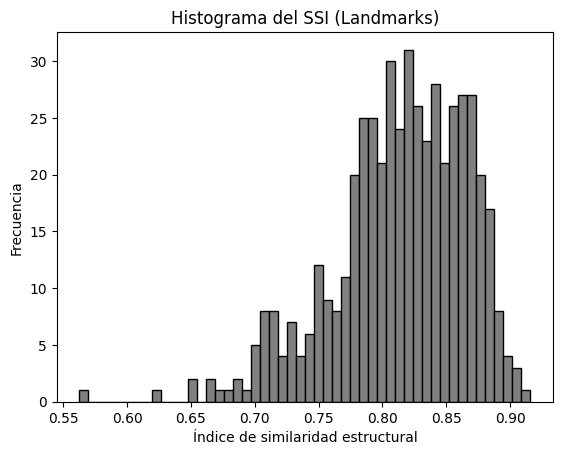

In [ ]:
plt.hist(values_landmarks, bins=50, color="gray", edgecolor="black")
plt.xlabel("Índice de similaridad estructural")
plt.ylabel("Frecuencia")
plt.title("Histograma del SSI (Landmarks)")